# Sc2ts vs Usher cophylogenies

## "Pango-representative" samples

To plot cophylogenies, we aim to find identical "representative samples" for Pango lineages that exist in both the Usher tree and the sc2ts tree, and have the same Pango assignment in both. 

However, the earliest sample of each Pango type could be an erroneous classication. To avoid this, this notebook identifies "originating nodes" for each pango. An originating node of (say) B.1.1.7 is the earliest node that has > 50% of the B.1.1.7 samples as descendants, and which itself is labelled B.1.1.7. As this is an ARG, there are many trees: we count the maximum number of samples in any tree. To find a representative sample, we pick the oldest descendant sample node of the origination node which has entirely B.1.1.7 samples as descendants in a tree.

To reduce the number of tips to compare, we also remove samples which are known Pango-X recombinants (and descendants of them).

In [1]:
import os
import tszip
import sc2ts

ts = tszip.load("../data/sc2ts_v1_2023-02-21_pp_dels_bps_pango_dated_mmps.trees.tsz")
df = sc2ts.node_data(ts)
df.set_index("sample_id", inplace=True)

# Get the associated data and join, so that we can use either "pango" or "Viridian_pangolin" defintions
ds = sc2ts.Dataset("../data/viridian_mafft_2024-10-14_v1.vcz")
df = df.join(ds.metadata.as_dataframe(["Date_tree", "Viridian_pangolin"]))

# Set which pango designation to use: try "pangolin" (native sc2ts) or "Viridian_pangolin" (assigned by viridian)
Pango = "Viridian_pangolin"

pango_lineage_samples = df[df.is_sample].groupby(Pango)['node_id'].apply(list).to_dict()
print(f"ARG has {len(pango_lineage_samples)} pango designations")

ARG has 2034 pango designations


In [2]:
import numpy as np
import collections
from tqdm.auto import tqdm
import tskit
import heapq

cutoff = 0.50

pango_representative_sample = {}

def find_first_fully_tracked_sample_by_time(tree, root):
    # Efficiently traverse nodes in time order using a priority queue
    # and return the oldest sample where all descendants are tracked.
    # Takes advantage of the fact that parents have older times than children.
    node_times = tree.tree_sequence.nodes_time
    if root == tskit.NULL:
        root = tree.virtual_root
    
    # Priority queue: (time, node)
    pq = [(-node_times[root], root)]
    while pq:
        time, u = heapq.heappop(pq)
        # Skip nodes with no tracked samples
        if tree.num_tracked_samples(u) == 0:
            continue
        # Check if this node is fully tracked
        if tree.num_samples(u) == tree.num_tracked_samples(u) and tree.is_sample(u):
            return u
        # Add children to priority queue (they have younger times)
        for child in tree.children(u):
            heapq.heappush(pq, (-node_times[child], child))
    return None  # No fully tracked node found


def origination_node(simp_ts, df, pango):
    nodes_time = simp_ts.nodes_time
    valid = {}
    samples = pango_lineage_samples[pango]
    if len(samples) == 0:
        return None
    # Find valid nodes: have same Pango type and > cutoff descendant samples in any tree

    tmp_df = df[df[Pango] == pango]  # Only look at the ones designated pango
    for tree in simp_ts.trees(tracked_samples=samples):
        for row in tmp_df.itertuples():
            u = row.Index
            tnts = tree.num_tracked_samples(u)
            if tnts > valid.get(u, 0):
                if tnts > len(samples) * cutoff:
                    valid[u] = tnts
    # Check through valid nodes for the best origination node: return a single element array if good
    if len(valid) == 0:
        return None
    else:
        return max(valid, key=valid.get)

        
        
def representative_node(ts, pango, pango_root):
    # descend from the root pango in each tree, but avoid any subtree that has no
    # tracked_samples
    for tree in ts.trees(tracked_samples=pango_lineage_samples[pango]):
        nd = find_first_fully_tracked_sample_by_time(tree, pango_root)
        if nd is not None:
            return nd
            

# For speed, simplify the ARG down to a set of subgroups of pango samples
# before looking for the sample descendants
pangos = list(pango_lineage_samples.keys())
n_batches = int(np.sqrt(len(pangos)))
poor_orig_nd_pct = {}
no_valid_orig_nd = []

pango_origin = {}
for i in tqdm(np.arange(n_batches)):
    batch = pangos[i::n_batches]
    tmp_df = df.set_index("node_id")
    tmp_df = tmp_df.loc[np.isin(df[Pango], batch)]
    samples = np.array([u for b in batch for u in pango_lineage_samples[b]])
    simp_ts = ts.simplify(samples, keep_unary=True, filter_nodes=False)
    for pango in tqdm(batch, leave=False):
        orig_nd = origination_node(simp_ts, tmp_df, pango)
        if orig_nd is None:
            no_valid_orig_nd.append(pango)
        else:
            best_nd = representative_node(ts, pango, orig_nd)
            if best_nd is not None:
                vv = df.loc[df.node_id == best_nd, Pango].values
                assert len(vv) == 1 and vv[0] == pango
                pango_representative_sample[pango] = best_nd
                

print(f"Found {len(pango_representative_sample)} pango sample nodes / {len(pango_lineage_samples)} pango groups")
print(f"{len(no_valid_orig_nd)} pangos rejected as no pango origination node with > {cutoff*100:.1f}% pango descendants:")
print(" " + ", ".join(no_valid_orig_nd))
#print(f"{len(poor_orig_nd_pct)} pangos rejected as pango origination node has < {cutoff * 100}% of those pango descendants:")
#print(" " + ", ".join([f"{k}: node {v[0]}@{v[1] * 100:.1f}%" for k, v in poor_orig_nd_pct.items()]))
sts = ts.simplify(
    [v for k, v in pango_representative_sample.items()
     if not k.startswith("X")
    ], keep_unary=True, filter_nodes=False)

print(f"Simplified ARG to representative non-pangoX samples: {sts.num_trees} trees and {sts.num_samples} samples")

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Found 962 pango sample nodes / 2034 pango groups
1069 pangos rejected as no pango origination node with > 50.0% pango descendants:
 A, AY.16, AY.4, AY.87, B.1.1.200, B.1.1.273, B.1.1.59, B.1.145, B.1.258.10, B.1.332, B.1.363, B.32, BA.1.1.7, BA.2.37, BA.2.75, BA.4.6.4, BA.5.2.10, BA.5.2.6, BE.4, BF.38, BN.1.4.1, BQ.1.1.36, CL.1.3, DE.2, FH.1, P.1.7.1, XBB.1.22.1, XBB.1.5.39, A.1, AY.4.1, AY.88, B.1.1.135, B.1.1.274, B.1.366, B.1.429, B.1.525, BA.2.38, BA.2.75.1, BA.5.2.12, BA.5.2.60, BE.4.1, BQ.1.1.37, BQ.1.10.3, CM.1, DF.1, EE.3, XBB.1.5.4, XR, A.2, AY.106, AY.4.10, AY.5.3, AY.9, B.1.1.136, B.1.1.275, B.1.1.348, B.1.1.421, B.1.1.62, B.1.147, B.1.258.12, B.1.336, B.1.367, B.1.526, B.1.605, B.34, BA.1.1.9, BA.2.38.1, BA.5.2.61, BF.39, BQ.1.1.38, BQ.1.11, BR.5, CE.1, P.2, XBB.2.4, XS, B.1.1.137, B.1.1.277, B.1.1.423, B.1.337, B.1.369, B.1.431, B.1.607, B.35, BA.2.18, BA.2.38.3, BA.2.75.2, BA.4.8, BA.5.2.14, BN.1.4.5, BQ.1.1.39, BQ.1.11.1, CM.2, DG.1, EE.5, Q.1, XBB.1.3, XBB.1.5.41, XBB.2

In [3]:
# Are there any samples with a recombination node immediately above
import collections

sts = ts.simplify(
    [v for k, v in pango_representative_sample.items()
     if not k.startswith("X")
    ], keep_unary=True, filter_nodes=False)

recombinants = np.where(sts.nodes_flags & sc2ts.NODE_IS_RECOMBINANT)[0]
## Make a dictionary, `sample_desc`, with the descendants of each sample node
sample_desc = collections.defaultdict(set)
for tree in sts.trees():
    for u in recombinants:
        if tree.num_samples(u) > 0:
            sample_desc[u] |= set(tree.samples(u))

for k, v in sample_desc.items():
    print(f"Node {k} ({ts.node(k).metadata['pango']}): {len(v)} descendant pangos")

one_sample_re = {list(v)[0] for v in sample_desc.values() if len(v) <= 1}

internal_nodes = set(sts.edges_parent)

sts = ts.simplify([
    v for k, v in pango_representative_sample.items()
    if (
        v not in one_sample_re and
        v not in internal_nodes and
        not k.startswith("X") and
        v not in sample_desc[1396207]  # Exclude descendants of XBB (some of these do not start with an X)
    )
], keep_unary=True, filter_nodes=False)

print(
    "After removing 3 singleton Pangos below a RE node, and further PangoX descendants "
    f" the ARG has {sts.num_trees} trees and {sts.num_samples} pangos")

sample_desc = collections.defaultdict(set)
for tree in sts.trees():
    for u in recombinants:
        if tree.num_samples(u) > 0:
            sample_desc[u] |= set(tree.samples(u))
for k, v in sample_desc.items():
    print(f"Node {k} ({ts.node(k).metadata['pango']}): {len(v)} descendant samples")

sample_desc[None] = set(sts.samples()) - set().union(*list(sample_desc.values()))
print(len(sample_desc[None]), "samples not under a RE node")

Node 200039 (B.1.617.2): 106 descendant pangos
Node 447368 (AY.80): 1 descendant pangos
Node 822854 (BA.2): 341 descendant pangos
Node 1189192 (BA.5): 197 descendant pangos
Node 1396207 (XBB): 17 descendant pangos
Node 1407336 (BA.2): 1 descendant pangos
Node 1432902 (BA.2): 1 descendant pangos
Node 1030562 (BA.2): 195 descendant pangos
After removing 3 singleton Pangos below a RE node, and further PangoX descendants  the ARG has 5 trees and 878 pangos
Node 200039 (B.1.617.2): 105 descendant samples
Node 822854 (BA.2): 322 descendant samples
Node 1189192 (BA.5): 195 descendant samples
Node 1030562 (BA.2): 195 descendant samples
451 samples not under a RE node


The 5 trees correspond to 4 recombination nodes.
* 200039 is the Delta recombinant, and is tree-like under that
* 822854 is the BA.2 recombinant. The BA.5 recombinant lies under this
* 1189192 is the BA.5 recombinant.
* 1030562 is probably wrong: the recombination node is on the far RHS @ 27382, and includes only 4 sites that differ between parents there

This can be seen in the copying pattern below

In [4]:
from IPython.display import HTML
HTML(
    "<style>table.copying-table {font-size: 8px} table.copying-table .pattern td {font-size: 0.5em; width:0.2em}</style>" +
    sc2ts.info.CopyingTable(ts, 1030562).html(child_label="1030562", show_bases=None)
)

pos,44,670,2470,2790,2832,4184,4321,5386,6513,6514,6515,7926,8393,9344,9424,9534,9866,10198,10447,11283,11284,11285,11286,11287,11292,11293,11294,11295,11296,11537,12880,13195,15714,16342,17410,19955,20055,21618,21633,21634,21635,21636,21637,21638,21639,21640,21641,21762,21765,21766,21767,21768,21769,21770,21846,21988,21989,21990,21991,21992,21993,21994,21995,22195,22197,22198,22200,22202,22204,22673,22688,22775,22898,23048,23202,24130,24503,26060,26530,26858,27382,27383,29510,29754
ref,C,T,C,C,A,G,C,T,G,T,T,C,G,C,A,C,C,C,G,G,T,T,T,G,G,T,T,T,T,A,C,T,C,T,C,C,A,C,T,A,C,C,C,C,C,T,G,C,T,A,C,A,T,G,C,T,G,T,T,T,A,T,T,T,T,A,T,C,T,T,A,G,G,G,C,C,C,C,A,C,G,A,A,C
P0,,,,,,,,,,,,,,,,,,,,,,,,,—,—,—,—,—,,,,,,,,,,—,—,—,—,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1030562,,,,,,,,,,,,,,,,,,,,,,,,,—,—,—,—,—,,,,,,,,,,—,—,—,—,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1,,,,,,,,,—,—,—,,,,,,,,,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,,,,,—,—,—,—,—,—,,—,—,—,—,—,—,—,—,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mut,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [5]:
print(" We treat descendants of the 1030562 fake 'recombinant' as non-recombining, by trimming aray the far RHS")
tables = sts.dump_tables()
tables.reference_sequence.clear()
bp_1030562 = (sts.edges_right[sts.edges_child == 1030562]).min()
tables.keep_intervals([[0, bp_1030562]], simplify=False)
tables.trim()
core_sc2ts = tables.tree_sequence()
core_df = sc2ts.node_data(core_sc2ts)
core_df_samples = core_df[core_df.is_sample]
core_df_samples.set_index("sample_id", inplace=True)
core_df_samples = core_df_samples.join(ds.metadata.as_dataframe(["Date_tree", "Viridian_pangolin"]))

core_sc2ts_map = {}
core_sc2ts_pango_map = {}
for row in core_df_samples.itertuples():
    core_sc2ts_map[row.Index] = row.node_id
    core_sc2ts_pango_map[getattr(row, Pango)] = row.Index
    
assert core_sc2ts.num_trees == 4  # 3 breakpoints

 We treat descendants of the 1030562 fake 'recombinant' as non-recombining, by trimming aray the far RHS


In [6]:
import tszip
from tqdm.auto import tqdm
uts = tszip.load("../usher_tree/viridian.dated_samples.trees") #all_viridian.202409.trees.tsz")
usher_map = {}
usher_pango = collections.defaultdict(list)
for u in tqdm(uts.samples()):
    nd = uts.node(u)
    usher_map[nd.metadata['strain']] = u

  0%|          | 0/4446273 [00:00<?, ?it/s]

In [7]:
joint_keys = core_sc2ts_map.keys() & usher_map.keys()
print("Found", len(joint_keys), "sample ids shared between the sc2ts ARG and the Usher tree")
pangos = {}  # Map the key (e.g. ERR10001879) to a pango
for k in joint_keys:
    try:
        pangos[k] = df.loc[k, Pango]
    except IndexError:
        print(k, "not found")
reverse_pangos = {v: k for k, v in pangos.items()}
pango_numbers = {k: len(pango_lineage_samples[pangos[k]]) for k in joint_keys}


Found 871 sample ids shared between the sc2ts ARG and the Usher tree


In [8]:
print("Aligning times between the Usher tree and the sc2ts tree")
core_sc2ts_nodes = np.array([core_sc2ts_map[k] for k in joint_keys])
usher_nodes = np.array([usher_map[k] for k in joint_keys])
time_diff = np.round((uts.nodes_time[usher_nodes]- core_sc2ts.nodes_time[core_sc2ts_nodes]).mean(), 5)
tables = uts.dump_tables()
tables.nodes.time = tables.nodes.time - time_diff
tables.mutations.time = tables.mutations.time - time_diff
usher_ts = tables.tree_sequence()

Aligning times between the Usher tree and the sc2ts tree


## Untangling algorithm

We use _dendroscope_ (Huson and Scornavacca, DOI:10.1093/sysbio/sys062) to untangle the trees. This is still the most effective software for untangling trees with polytomies.

In [9]:
dendroscope_binary = "/Applications/Dendroscope/Dendroscope.app/Contents/MacOS/JavaApplicationStub"

import tempfile
import subprocess
import re

def run_dendroscope_untangle(ts_2_trees):
    # Uses the Neighbor-net heuristic algorithm, which works well with polytomies
    assert ts_2_trees.num_trees == 2
    with tempfile.TemporaryDirectory() as tmpdirname:
        newick_path = os.path.join(tmpdirname, "cophylo.nwk")
        command_path = os.path.join(tmpdirname, "commands.txt")
        with open(newick_path, "wt") as file:
            for tree in ts_2_trees.trees():
                print(tree.as_newick(), file=file)
        with open(command_path, "wt") as file:
            print(f"open file='{newick_path}';", file=file)
            print("compute tanglegram method=nnet", file=file)
            print(
                f"save format=newick file='{newick_path}'", file=file
            )  # overwrite
            print("quit;", file=file)
        subprocess.run([dendroscope_binary, "-g", "-c", command_path])
        order = []
        with open(newick_path, "rt") as newicks:
            for line in newicks:
                # hack: use the order of `nX encoded in the string
                order.append([int(n[1:]) for n in re.findall(r"n\d+", line)])
    return order


def make_joint_ts(sc2ts_ts, usher_ts):
    """
    Combine two tree sequences of one tree each into a single tree sequence of 2 trees using
    the metadata name "strain" from the first and "sample_id" from the second.
    """
    if sc2ts_ts.num_trees > 1 or usher_ts.num_trees > 1:
        raise ValueError(f"Found {sc2ts_ts.num_trees} trees in the first ts")
    sc2ts_node_map = {nd.metadata['sample_id']: nd.id for nd in sc2ts_ts.nodes() if nd.is_sample()}
    usher_to_sc2ts_node_map = [sc2ts_node_map.get(nd.metadata.get('strain'), tskit.NULL) for nd in usher_ts.nodes()]
    ts = sc2ts_ts.concatenate(usher_ts, node_mappings=[usher_to_sc2ts_node_map])
    print(f"\tReturning a joint tree sequence with {ts.num_samples} samples, classified as:")
    for k, v in collections.Counter([ts.node(u).metadata['scorpio'] for u in ts.samples()]).items():
        print(f"\t\t{k}: {v} samples")
    return ts


In [10]:
import tskit
import numpy as np

def node_positions(svgtree):
    x = svgtree.node_x_coord
    node_times = svgtree.ts.nodes_time
    if svgtree.time_scale == "rank":
        within_tree_node_times = np.unique(node_times[svgtree.tree.preorder()])
        node_times = np.searchsorted(within_tree_node_times, node_times)
    y = svgtree.timescaling.transform(node_times)
    return x, y


def tanglegram(
    ts,
    tree_indexes=None,
    titles=None,
    *,
    size=None,
    order=None,
    separation=None,
    line_gap=None,
    node_labels=None,
    style=None,
    x_axis=None,
    x_label=None,
    x_ticks=None,
    x_gridlines=None,
    y_axis=None,
    y_label=None,
    y_ticks=None,
    y_gridlines=None,
    tweak_rh_lab=0,
    **kwargs
):
    r"""
    Create an SvgTree object describing a "tanglegram" that compares the topology leading
    to leaf nodes on two trees in a tree sequence, by drawing them facing each other, and
    plotting lines between the same leaves in each tree. By default, compare the first
    and last non-empty tree, and plot titles based on the tree indexes. This does not
    "untangle" the trees to minimise the number of line crossings, but simply
    plots them using the default "minlex" order. If you wish to do untangle them,
    you will need to use an external program to calculate the leaf orders, and
    pass them in through the `order` parameter. The separate plots can be styled
    as the left and right SVGs are given `lft_tree` and ``rgt_tree` classes.

    .. note::
        If you have two trees from separate tree sequences, you can concatenate them
        together using :meth:`tskit.TreeSequence.concatenate()`, providing a
        node_mapping to match leaf or sample nodes between the two trees, and
        then pass the resulting tree sequence to this function.

    :param TreeSequence ts: The tree sequence from which to take trees
    :param tuple tree_indexes: A tuple of two integers, the indexes of the two trees to
        compare. By default take the first and last non-empty trees in the tree sequence.
    :param tuple titles: A tuple of two strings, the titles to use for the left and right
        trees. By default show "Tree X". To show no titles, provide titles=(None, None).
    :param tuple size: A tuple of two integers, the width and height of the SVG image.
        By default, use the default (square) size per tree, giving (400, 200) in total.
    :param tuple order: A tuple of two lists of integers, the order in which to plot the
        leaves. Either list can be `None`, meaning default to ``minlex_postorder``.
        If either is a list, it must contain unique integers corresponding to the IDs
        of the leaves in the corresponding tree, with the length of each list matching
        the number of leaves in the tree. Default: ``None`` treated as ``(None, None)``.
    :param float separation: The distance between the base of each tree. Default:
        ``None`` treated as a standard distance of 64px.
    :param float line_gap: The distance between tangle_lines and each leaf on the tree.
        If None, draw tangle lines of equal length in the middle of the plot
    :param str path: A path to which the SVG will be saved.
    :param dict node_labels: A dictionary mapping node IDs to label to plot. See
        :meth:`Tree.draw_svg()` for details.
    :param str style: a string of CSS styles. See :meth:`Tree.draw_svg()` for details.
    :param bool x_axis: Should we plot two horizontal axes showing time underneath
        the trees. Note that this corresponds to the y-axis in a conventional
        SVG plot, as tanglegrams are rotated 90°.
    :param str x_label: X axis label (equivalent of ``y_label`` in ``draw_svg()``).
    :param Union[list, dict] x_ticks: Location of the tick marks on the time axis
        (equivalent of ``y_ticks`` in ``draw_svg()``).
    :param bool x_gridlines: Whether to plot vertical lines behind the tree
        at each y tickmark (equivalent of ``y_gridlines`` in ``draw_svg()``).
    :param bool y_axis: Equivalent of `x_axis` parameter in ``draw_svg()``.
        Probably not what you want.
    :param bool y_label: Equivalent of `y_label` parameter in ``draw_svg()``
        Probably not what you want.
    :param bool y_ticks: Dummy option: has no effect
    :param bool y_gridlines: Dummy option: has no effect
    :param \**kwargs: Additional keyword arguments to pass to :meth:`Tree.draw_svg()`,
        such as `time_scale` ("log_time", "rank", etc)

    :returns:
        A tuple of an SvgTree object (that can be plotted by calling obj.draw()) and a left
        and a right node mapping.
    """
    def make_reverse_map(node_map):
        reverse_map = np.zeros_like(node_map)
        kept = node_map != tskit.NULL
        reverse_map[node_map[kept]] = np.arange(len(node_map))[kept]
        return reverse_map

    def reorder_tree_nodes(tree, node_order):
        # given a node order and a tree, make a new tree and return that and the order
        node_map = np.arange(tree.tree_sequence.num_nodes)
        node_map[np.sort(node_order)] = node_order
        ts = tree.tree_sequence.subset(node_map, False, False, False)
        return node_map, ts.at_index(tree.index)

    def get_valid_leaf_order(tree, node_order):
        # take a node ordering and return a leaf ordering on the reordered-node tree
        if len(np.unique(node_order)) != len(node_order):
            raise ValueError("Order must contain unique integers")
        node_map, tree = reorder_tree_nodes(tree, node_order)
        leaves = np.array([u for u in tree.nodes(order="minlex_postorder") if tree.is_leaf(u)])
        return node_map[leaves]

    if y_ticks is not None:
        raise ValueError("Invalid option")
    if y_gridlines is not None:
        raise ValueError("Invalid option")
    if order is None:
        order = (None, None)
    if tree_indexes is None:
        tree_indexes = (
            1 if ts.first().num_edges == 0 else 0,
            -2 if ts.last().num_edges == 0 else -1,
        )
    lft = ts.at_index(tree_indexes[0])
    rgt = ts.at_index(tree_indexes[1])
    if titles is None:
        titles = (f"Tree {lft.index}", f"Tree {rgt.index}")

    if separation is None:
        extra_sep = 0
    else:
        extra_sep = separation - 64
    if size is None:
        # Note that the width is twice the default tree height, as these are rotated
        size = (200 * 2, 200)
    w = size[0] / 2  # width (tree height) of one of the plotted trees, after 90° rotation
    height = size[1]
    style = (
        ".lft_tree > g.tree, .lft_tree > g.tangle_lines {transform: translate(0, " + str(height) + "px) rotate(-90deg);}" +
        ".lft_tree > g.tree .node > .lab {text-anchor: start; transform: rotate(90deg) translate(3px);}"
        ".lft_tree > .title {transform: translate(" + str(w/2) + "px);}"
        ".rgt_tree > g.tree {transform: translate(" + str(w) + "px, 0) rotate(90deg);}"
        ".rgt_tree > g.tree .node > .lab {text-anchor: end; transform: rotate(-90deg) translate(" + str(-3-tweak_rh_lab) + "px);}"     
        ".rgt_tree > .title {transform: translate(" + str(w/2) + "px);}"
        ".lft_tree .axes .y-axis .title text {transform: translate(11px) rotate(90deg);}"
        ".rgt_tree .axes .y-axis .title text {transform: translate(-11px) rotate(-90deg);}"
        ".rgt_tree .axes .y-axis .ticks .lab {text-anchor: end; transform: rotate(180deg);}"
    ) + (style or "")

    
    # For tree 1 we need to reverse the plotting order of leaves, so the leftmost
    # tip appears at the top when the tree is rotated 90° anticlockwise. We do this
    # by reordering using `subset()`, so minlex order will reverse the current order
    # This also means we need to re-adjust the node labels, as the sample IDs will change
    if node_labels is None:
        node_labels = {u: str(u) for u in np.arange(ts.num_nodes)}

    if order[0] is None:
        leaves = np.array([u for u in lft.nodes(order="minlex_postorder") if lft.is_leaf(u)])[::-1]
    else:
        leaves = get_valid_leaf_order(lft, order[0][::-1])
        
    lft_node_map, lft = reorder_tree_nodes(lft, leaves)
    lft_rev_map = make_reverse_map(lft_node_map)
    # Have to change the node labels, because even provided ones will be targetting the wrong IDs
    lft_node_labels = {u: node_labels[v] for u, v in enumerate(lft_node_map) if v in node_labels}
    if order[1] is None:
        # We do not reorder the RH tree, so the node IDs should stay as-is
        # TODO - we could check the leaf IDs match here
        rgt_node_labels = node_labels
        rgt_node_map = rgt_rev_map = np.arange(ts.num_nodes)
    else:
        rleaves = get_valid_leaf_order(rgt, order[1])
        rgt_node_map, rgt = reorder_tree_nodes(rgt, rleaves)
        if set(rleaves) != set(leaves):
            raise ValueError("Leaf IDs in the two trees are not the same")
        rgt_node_labels = {u: node_labels[v] for u, v in enumerate(rgt_node_map) if v in node_labels}
        rgt_rev_map = make_reverse_map(rgt_node_map)
    kwargs["size"] = (height, w)
    kwargs["order"] = "minlex_postorder"
    kwargs["y_label"] = x_label  # Swapped because of 90° rotation
    kwargs["y_ticks"] = x_ticks  # Swapped because of 90° rotation
    kwargs["y_gridlines"] = x_gridlines  # Swapped because of 90° rotation
    kwargs["x_axis"] = y_axis  # Swapped because of 90° rotation
    kwargs["x_label"] = y_label  # Swapped because of 90° rotation
    # We'll embed the right tree and the tangle lines within the left tree later, via the preamble
    svgtree_lft = tskit.drawing.SvgTree(
        lft,
        title=titles[0],
        canvas_size=(w * 2 + extra_sep, height),
        node_labels=lft_node_labels,
        root_svg_attributes={'class': 'lft_tree'},
        y_axis=x_axis,
        **kwargs,
    )
    svgtree_rgt = tskit.drawing.SvgTree(
        rgt,
        title=titles[1],
        canvas_size=(w, height),
        node_labels=rgt_node_labels,
        root_svg_attributes={'class': 'rgt_tree', 'x': w + extra_sep},
        y_axis='right' if x_axis else x_axis,
        style=style,
        **kwargs,
    )
    x_lft, y_lft = node_positions(svgtree_lft)

    # Here we just need any list of leaves (order doesn't matter, as long as it's consistent)
    tip_h_lft = [x_lft[u] for u in lft_rev_map[leaves]]
    tip_w_lft = y_lft[lft_rev_map[leaves]]
    tip_w_lft = np.full_like(tip_w_lft, w - 10) if line_gap is None else (tip_w_lft + line_gap)

    x_rgt, y_rgt = node_positions(svgtree_rgt)
    tip_h_rgt = [x_rgt[u] for u in rgt_rev_map[leaves]]
    tip_w_rgt = y_rgt[rgt_rev_map[leaves]]
    tip_w_rgt = np.full_like(tip_w_rgt, w - 10) if line_gap is None else (tip_w_rgt + line_gap)
    
    lines = [
        f'<line stroke="blue" x1="{x1}" y1="{y1}" x2="{height-x2}" y2="{w*2 + extra_sep - y2}" />'
        for x1, y1, x2, y2 in zip(tip_h_lft, tip_w_lft, tip_h_rgt, tip_w_rgt)
    ]

    svgtree_lft.preamble = (  # Add the RH tree plus lines as the preamble
        '<g class="tangle_lines">' + ''.join(lines) + '</g>' + svgtree_rgt.draw()
    )
    return svgtree_lft, lft_rev_map, rgt_rev_map

## Restricting to important pangos


In [11]:
min_samples = 5
print(f"Only plotting Pango lineages that have over {min_samples} sequenced samples")

edges = core_sc2ts.edges_child == 200039
delta_parents = {k: v for k, v in zip(core_sc2ts.edges_right[edges], core_sc2ts.edges_parent[edges])}
delta_parents = [delta_parents[k] for k in sorted(delta_parents.keys())]
delta_parents = {reverse_pangos[p]: p for p in df.loc[np.isin(df.node_id, delta_parents), "pango"]}

edges = core_sc2ts.edges_child == 822854
ba2_parents = {k: v for k, v in zip(core_sc2ts.edges_right[edges], core_sc2ts.edges_parent[edges])}
ba2_parents = [ba2_parents[k] for k in sorted(ba2_parents.keys())]
ba2_parents = {reverse_pangos[p]: p for p in df.loc[np.isin(df.node_id, ba2_parents), "pango"]}

try:
    edges = core_sc2ts.edges_child == 1189192
    ba5_parents = {k: v for k, v in zip(core_sc2ts.edges_right[edges], core_sc2ts.edges_parent[edges])}
    ba5_parents = [ba5_parents[k] for k in sorted(ba5_parents.keys())]
    ba5_parents = {reverse_pangos[p]: p for p in df.loc[np.isin(df.node_id, ba5_parents), "pango"]}
except KeyError:
    #print(f"Could not find samples representing {df.loc[np.isin(df.node_id, ba5_parents), "pango"].values}")
    ba5_parents = {}

print("\n")

print("Root tree")
use = [k for k in joint_keys if core_sc2ts_map[k] in sample_desc[None] and pango_numbers[k] > min_samples]
use = np.union1d(use, list(delta_parents.keys() | ba2_parents.keys() | ba5_parents.keys()))
base_ts = make_joint_ts(
    core_sc2ts.simplify([core_sc2ts_map[k] for k in use], keep_input_roots=True),
    usher_ts.simplify([usher_map[k] for k in use], keep_input_roots=True),
)

print("Delta subtree")
use = [k for k in joint_keys if core_sc2ts_map[k] in sample_desc[200039] and pango_numbers[k] > min_samples]
delta_ts = make_joint_ts(
    core_sc2ts.simplify([core_sc2ts_map[k] for k in use], keep_input_roots=True),
    usher_ts.simplify([usher_map[k] for k in use], keep_input_roots=True),
)

print("BA.2 subtree")
use = [
    k for k in joint_keys if (
        core_sc2ts_map[k] in sample_desc[822854] and
        core_sc2ts_map[k] not in sample_desc[1189192] and
        pango_numbers[k] > min_samples
    )
]
ba2_ts = make_joint_ts(
    core_sc2ts.simplify([core_sc2ts_map[k] for k in use], keep_input_roots=True),
    usher_ts.simplify([usher_map[k] for k in use], keep_input_roots=True),
)

print("BA.5 subtree")
use = [
    k for k in joint_keys if (
        core_sc2ts_map[k] in sample_desc[1189192] and
        #core_sc2ts_map[k] not in sample_desc[1189192] and
        pango_numbers[k] > min_samples
    )
]
ba5_ts = make_joint_ts(
    core_sc2ts.simplify([core_sc2ts_map[k] for k in use], keep_input_roots=True),
    usher_ts.simplify([usher_map[k] for k in use], keep_input_roots=True),
)

Only plotting Pango lineages that have over 5 sequenced samples


Root tree
	Returning a joint tree sequence with 304 samples, classified as:
		nan: 267 samples
		Alpha (B.1.1.7-like): 3 samples
		B.1.617.1-like: 1 samples
		Gamma (P.1-like): 3 samples
		Omicron (BA.1-like): 26 samples
		Beta (B.1.351-like): 1 samples
		Epsilon (B.1.429-like): 1 samples
		Mu (B.1.621-like): 1 samples
		Epsilon (B.1.427-like): 1 samples
Delta subtree
	Returning a joint tree sequence with 89 samples, classified as:
		Delta (B.1.617.2-like): 81 samples
		Delta (AY.4.2-like): 2 samples
		Delta (B.1.617.2-like) +K417N: 2 samples
		Delta (AY.4-like): 4 samples
BA.2 subtree
	Returning a joint tree sequence with 87 samples, classified as:
		Omicron (BA.2-like): 81 samples
		Omicron (BA.4-like): 6 samples
BA.5 subtree
	Returning a joint tree sequence with 143 samples, classified as:
		Omicron (BA.5-like): 143 samples


In [12]:
def sc2ts_tanglegram(ts, size=(800, 800), time_scale="rank", line_gap=40, separation=100, style="", label="", **kwargs):
    return tanglegram(
        ts, size=size, omit_sites=True, time_scale=time_scale, line_gap=line_gap,
        titles=(f"Sc2ts {label} tree", f"Usher {label} tree"),
        style="g.tangle_lines line {stroke: lightgrey} .sample .lab {font-size: 8px}" + style,
        node_labels={u: pangos[ts.node(u).metadata['sample_id']] for u in ts.samples()},
        separation=separation,
        **kwargs
    )

In [13]:
ds_base_orders = run_dendroscope_untangle(base_ts)

Version   Dendroscope (version 3.8.10, built 6 Sep 2023)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2023  Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms of the GNU General Public License, Version 3.
Java version: 18.0.2.1; max memory: 15.8G
Java version: 18.0.2.1

Trees loaded: 2
Compute tanglegram: Initialization
Neighbor-net heuristic
The minimal crossing number found is 2
Time needed for computation: 7 min.
--------------------------
Saving file: /var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/tmpbw9s0zre/cophylo.nwk
written 2 trees


In [14]:
import datetime

x_ticks = {}
zero = datetime.date.fromisoformat(base_ts.metadata["time_zero_date"])
months = list(range(1, 13))  # 1 to 12

target_dates = (
    [datetime.date(2023, 2, 1)] + [datetime.date(2023, 1, 1)] + # 2023: Jan, Feb only
    [datetime.date(year, month, 1) for year in [2022, 2021, 2020, 2019] for month in reversed(months)]
)
for target_date in target_dates:
    days_difference = (zero - target_date).days
    x_ticks[days_difference] = target_date.strftime("%Y-%m")


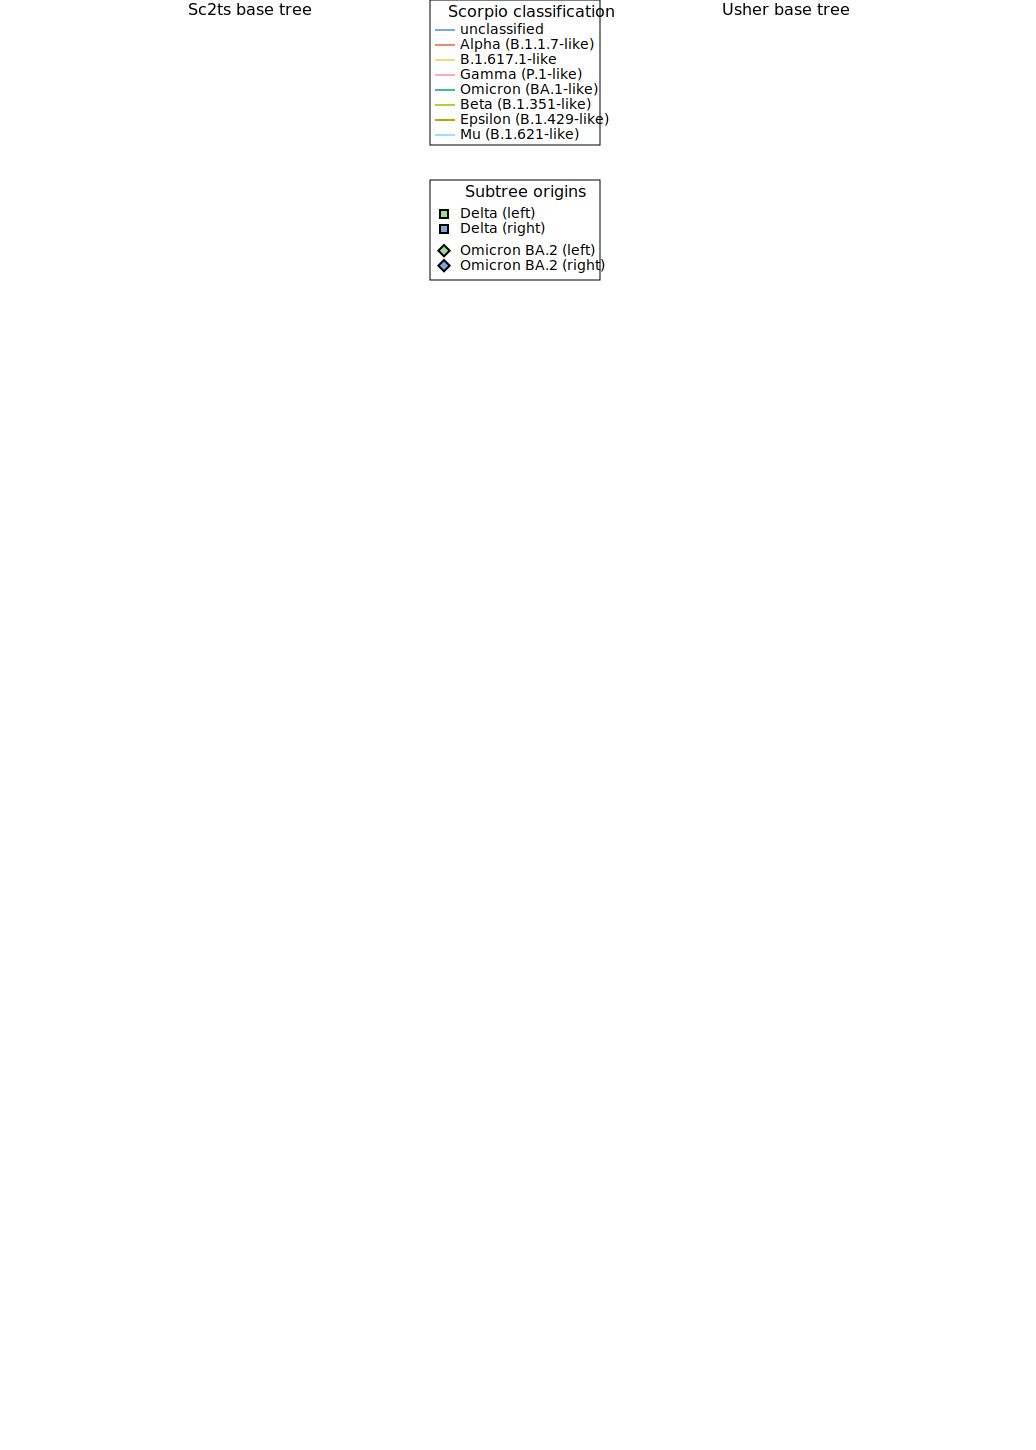

In [15]:
scorpios = collections.defaultdict(list)
sample_id_to_node_id = {}
for u in base_ts.samples():
    nd = base_ts.node(u)
    s = nd.metadata['scorpio']
    s = "unclassified" if s=="nan" else s
    scorpios[s].append(u)
    sample_id_to_node_id[nd.metadata["sample_id"]] = u

colours = ["#77AADD", "#EE8866", "#EEDD88", "#FFAABB", "#44BB99", "#BBCC33", "#AAAA00", "#99DDFF",]

tg, lft_map, rgt_map = sc2ts_tanglegram(
    base_ts, label="base", order=ds_base_orders, size=(1000, 1450), symbol_size=2, x_axis=True,
    x_ticks={k: v for k, v, in x_ticks.items() if 400 < k < 1200}, time_scale="time",
)

styles = [
    ",".join([f".rgt_tree .tree .n{rgt_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += [
    ",".join([f".lft_tree > .tree .n{lft_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += ['.y-axis .ticks .lab {font-size: 10px; font-family: "Arial Narrow"}']

legend = (
    '<g transform="translate(430 0)">' +
    '<rect x="0" y="0" width="170" height="145" fill="white" stroke="black" />' +
    '<text x="18" y="17" font-style="italic">Scorpio classification</text>' +
    "".join([
        (f'<line x1="5" x2="25" y1="{30 + 15*i}" y2="{30 + 15*i}" stroke="{c}" stroke-width="2" />'
         f'<text x="30" y="{34 + 15 * i}" font-size="14px">{label}</text>'
        )
        for i, (c, label) in enumerate(zip(colours, scorpios.keys()))
    ]) +
    '</g>'

    '<g transform="translate(430 180)">' +
    '<rect x="0" y="0" width="170" height="100" fill="white" stroke="black" />' +
    '<text x="35" y="17" font-style="italic">Subtree origins</text>' +
    '<rect x="10" height="8" y="30" width="8" stroke="black" stroke-width="2" fill="#9CDB90"/>' +
    '<text x="30" y="38" font-size="14px">Delta (left)</text>' +
    '<rect x="10" height="8" y="45" width="8" stroke="black" stroke-width="2" fill="#76A8D8" />' +
    '<text x="30" y="53" font-size="14px">Delta (right)</text>' +
    '<rect height="8" width="8" stroke="black" stroke-width="2" transform="translate(14, 65) rotate(45)" fill="#9CDB90" />' +
    '<text x="30" y="75" font-size="14px">Omicron BA.2 (left)</text>' +
    '<rect height="8" width="8" stroke="black" stroke-width="2" transform="translate(14, 80) rotate(45)" fill="#76A8D8" />' +
    '<text x="30" y="90" font-size="14px">Omicron BA.2 (right)</text>' +
    '</g>'
        
)

delta_node_ids = [sample_id_to_node_id[k] for k in delta_parents.keys()]
styles += [f".lft_tree > .tree .node.n{lft_map[u]} .sym {{transform: scale(3); stroke: black; stroke-width: 0.5px; fill: {c};}}"
           for u, c in zip(delta_node_ids, ("#9CDB90", "#76A8D8"))]
ba2_node_ids = [sample_id_to_node_id[k] for k in ba2_parents.keys()]
styles += [f".lft_tree > .tree .node.n{lft_map[u]} .sym {{transform: scale(3) rotate(45deg); stroke: black; stroke-width: 0.5px; fill: {c};}}"
           for u, c in zip(ba2_node_ids, ("#9CDB90", "#76A8D8"))]
tg.preamble = "<style>" + "".join(styles) + "</style>" + tg.preamble + legend

tg.draw()

In [16]:
ds_delta_orders = run_dendroscope_untangle(delta_ts)

Version   Dendroscope (version 3.8.10, built 6 Sep 2023)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2023  Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms of the GNU General Public License, Version 3.
Java version: 18.0.2.1; max memory: 15.8G
Java version: 18.0.2.1

Trees loaded: 2
Compute tanglegram: Initialization
Neighbor-net heuristic
The minimal crossing number found is 0
Time needed for computation: 5 s.
--------------------------
Saving file: /var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/tmpy7_31iz6/cophylo.nwk
written 2 trees


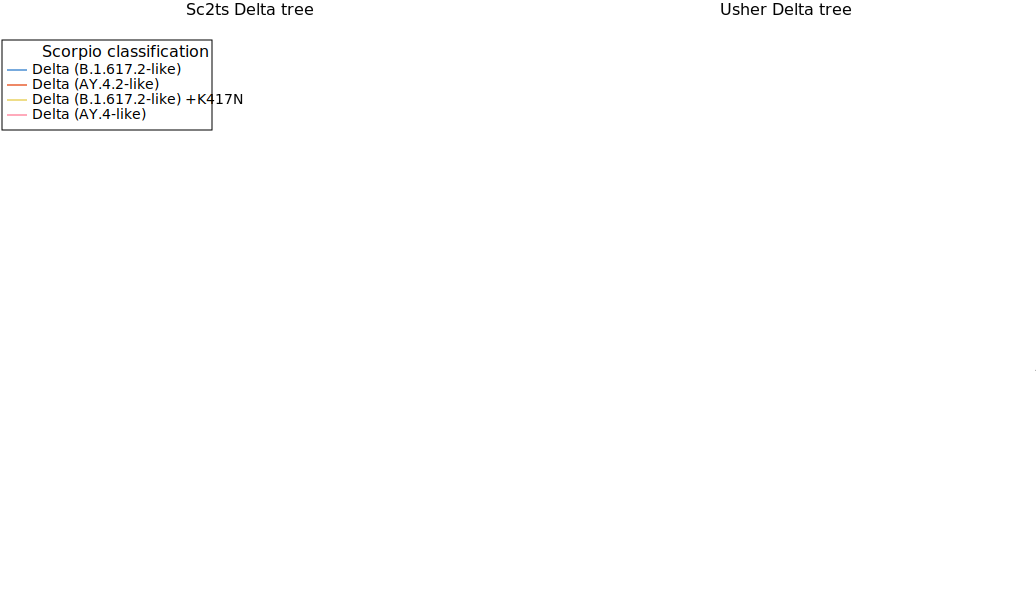

In [17]:
scorpios = collections.defaultdict(list)
for u in delta_ts.samples():
    scorpios[delta_ts.node(u).metadata['scorpio']].append(u)

colours = ["#77AADD", "#EE8866", "#EEDD88", "#FFAABB", "#44BB99", "#BBCC33", "#AAAA00", "#99DDFF",]

tg, lft_map, rgt_map = sc2ts_tanglegram(
    delta_ts, label="Delta", order=ds_delta_orders, size=(1000, 600), symbol_size=2,
    x_axis=True, x_ticks={k: v for k, v, in x_ticks.items() if 450 < k < 1200}, time_scale="time", 
    tweak_rh_lab=-2.5,
)

styles = [
    ",".join([f".rgt_tree .tree .n{rgt_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += [
    ",".join([f".lft_tree > .tree .n{lft_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += ['.y-axis .ticks .lab {font-size: 10px; font-family: "Arial Narrow"}']

legend = (
    '<g transform="translate(2 40)">' +
    '<rect x="0" y="0" width="210" height="90" fill="white" stroke="black" />' +
    '<text x="40" y="17" font-style="italic">Scorpio classification</text>' +
    "".join([
        (f'<line x1="5" x2="25" y1="{30 + 15*i}" y2="{30 + 15*i}" stroke="{c}" stroke-width="2" />'
         f'<text x="30" y="{34 + 15 * i}" font-size="14px">{label}</text>'
        )
        for i, (c, label) in enumerate(zip(colours, scorpios.keys()))
    ]) +
    '</g>'        
)
tg.preamble = "<style>" + "".join(styles) + "</style>" + tg.preamble + legend

tg.draw()


In [18]:
ds_ba2_orders = run_dendroscope_untangle(ba2_ts)

Version   Dendroscope (version 3.8.10, built 6 Sep 2023)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2023  Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms of the GNU General Public License, Version 3.
Java version: 18.0.2.1; max memory: 15.8G
Java version: 18.0.2.1

Trees loaded: 2
Compute tanglegram: Initialization
Neighbor-net heuristic
The minimal crossing number found is 41
Time needed for computation: 14 s.
--------------------------
Saving file: /var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/tmpgde7su2q/cophylo.nwk
written 2 trees


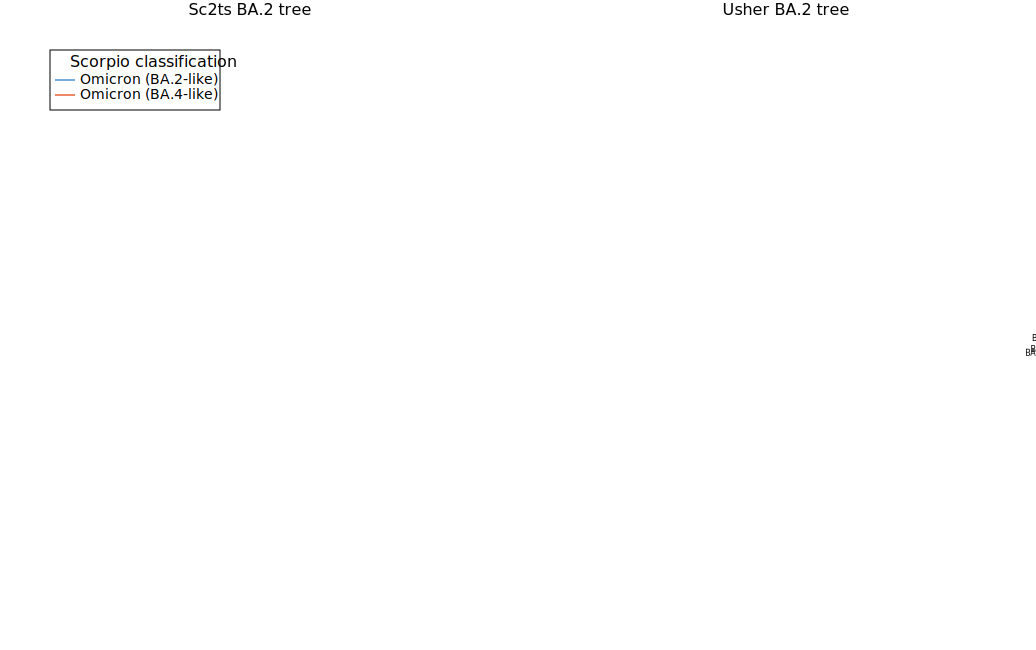

In [19]:
scorpios = collections.defaultdict(list)
for u in ba2_ts.samples():
    scorpios[ba2_ts.node(u).metadata['scorpio']].append(u)

colours = ["#77AADD", "#EE8866", "#EEDD88", "#FFAABB", "#44BB99", "#BBCC33", "#AAAA00", "#99DDFF",]

tg, lft_map, rgt_map = sc2ts_tanglegram(
    ba2_ts, label="BA.2", order=ds_ba2_orders, size=(1000, 650), symbol_size=2,
    x_axis=True, x_ticks={k: v for k, v, in x_ticks.items() if 40 < k < 1200}, time_scale="time", 
    #tweak_rh_lab=-2.5,
)

styles = [
    ",".join([f".rgt_tree .tree .n{rgt_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += [
    ",".join([f".lft_tree > .tree .n{lft_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += ['.y-axis .ticks .lab {font-size: 10px; font-family: "Arial Narrow"}']


legend = (
    '<g transform="translate(50 50)">' +
    '<rect x="0" y="0" width="170" height="60" fill="white" stroke="black" />' +
    '<text x="20" y="17" font-style="italic">Scorpio classification</text>' +
    "".join([
        (f'<line x1="5" x2="25" y1="{30 + 15*i}" y2="{30 + 15*i}" stroke="{c}" stroke-width="2" />'
         f'<text x="30" y="{34 + 15 * i}" font-size="14px">{label}</text>'
        )
        for i, (c, label) in enumerate(zip(colours, scorpios.keys()))
    ]) +
    '</g>'        
)
tg.preamble = "<style>" + "".join(styles) + "</style>" + tg.preamble + legend

tg.draw()


In [20]:
ds_ba5_orders = run_dendroscope_untangle(ba5_ts)

Version   Dendroscope (version 3.8.10, built 6 Sep 2023)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2023  Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms of the GNU General Public License, Version 3.
Java version: 18.0.2.1; max memory: 15.8G
Java version: 18.0.2.1

Trees loaded: 2
Compute tanglegram: Initialization
Neighbor-net heuristic
The minimal crossing number found is 0
Time needed for computation: 10 s.
--------------------------
Saving file: /var/folders/tj/03zrlgjj54qfndzhwrgp3tqc0000gn/T/tmp7413c0gb/cophylo.nwk
written 2 trees


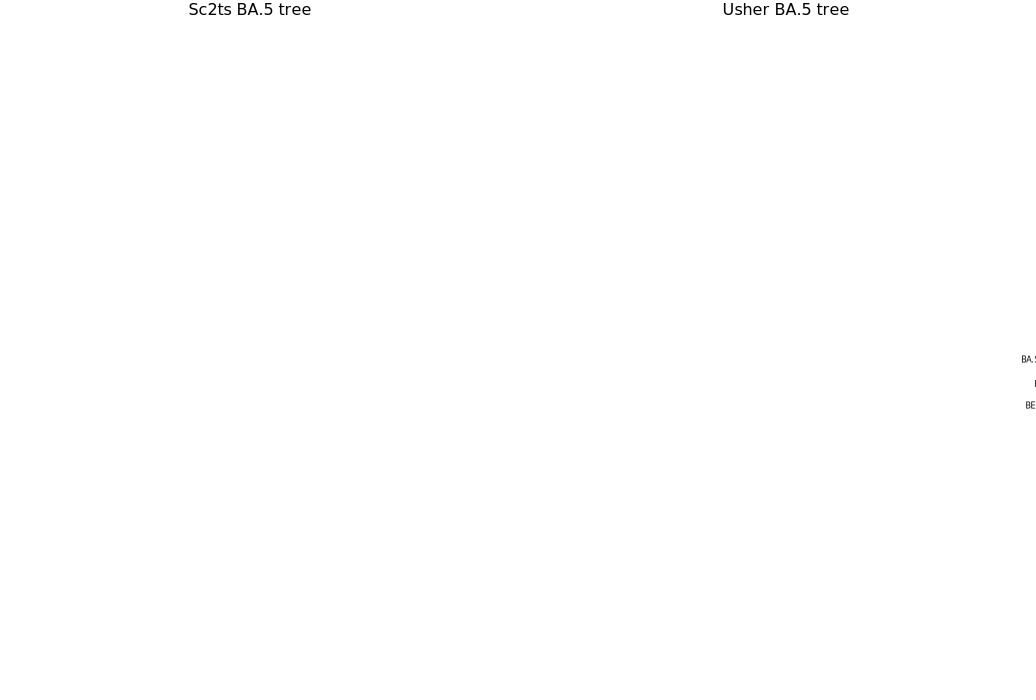

In [21]:
scorpios = collections.defaultdict(list)
for u in ba5_ts.samples():
    scorpios[ba5_ts.node(u).metadata['scorpio']].append(u)
    
colours = ["#77AADD", "#EE8866", "#EEDD88", "#FFAABB", "#44BB99", "#BBCC33", "#AAAA00", "#99DDFF",]

tg, lft_map, rgt_map = sc2ts_tanglegram(
    ba5_ts, label="BA.5", order=ds_ba5_orders, size=(1000, 700), symbol_size=2,
    x_axis=True, x_ticks={k: v for k, v, in x_ticks.items() if 0 < k < 1100}, time_scale="time", 
)

styles = [
    ",".join([f".rgt_tree .tree .n{rgt_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += [
    ",".join([f".lft_tree > .tree .n{lft_map[u]} .edge" for u in v]) + f"{{stroke: {c}}}"
    for c, (k, v) in zip(colours, scorpios.items())
]
styles += ['.y-axis .ticks .lab {font-size: 10px; font-family: "Arial Narrow"}']


tg.preamble = "<style>" + "".join(styles) + "</style>" + tg.preamble

tg.draw()
